In [1]:
############################################################
# Implementation of the cal_example_zerox.m
# Used to verify the code base works without errors.
############################################################

import numpy as np
import matplotlib.pyplot as plt
import arviz

from mcmc.mcmc import MCMC
from mcmc.data import Data
# from mcmc.chain import Chain
from mcmc.parameter import Parameter

from mcmc.models.kennedyohagan.model1 import Model

# Setup Model

In [2]:
#################
##### MODEL #####
#################

model = Model(
    params={
        'theta': Parameter(
            'theta',
            np.array([0.4]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_eta': Parameter(
            'omega_eta',
            np.array([
                np.exp(-50/4), 
                np.exp(-7/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'omega_delta': Parameter(
            'omega_delta',
            np.array([
                np.exp(-2/4)
            ]),
            bounded_below=0,
            bounded_above=1,
        ),
        'lambda_eta': Parameter(
            'lambda_eta',
            np.array([1]),
            positive=True,
        ),
        'lambda_delta': Parameter(
            'lambda_delta',
            np.array([30]),
            positive=True,
        ),
        'lambda_epsilon': Parameter(
            'lambda_epsilon',
            np.array([1000]),
            positive=True,
        ),
        'lambda_epsilon_eta': Parameter(
            'lambda_epsilon_eta',
            np.array([10000]),
            positive=True,
        )
    }
)

# Setup Data

In [3]:

################
##### DATA #####
################

DATAFIELD = np.loadtxt('data/simple_field_medium.csv', delimiter=',', dtype=np.float32)
DATACOMP = np.loadtxt('data/simple_comp.csv', delimiter=',', dtype=np.float32)

xf = np.reshape(DATAFIELD[:, 0], (-1, 1))
xc = np.reshape(DATACOMP[:, 0], (-1,1))
tc = np.reshape(DATACOMP[:, 1], (-1,1))
yf = np.reshape(DATAFIELD[:, 1], (-1,1))
yc = np.reshape(DATACOMP[:, 2], (-1,1))



#Standardize full response using mean and std of yc
yc_mean = np.mean(yc)
yc_std = np.std(yc)
x_min = min(xf.min(), xc.min())
x_max = max(xf.max(), xc.max())
t_min = tc.min()
t_max = tc.max()

xf_normalized = (xf - x_min)/(x_max - x_min)
xc_normalized = (xc - x_min)/(x_max - x_min)
# tc_normalized = np.zeros_like(tc)
# for k in range(tc.shape[1]):
#     tc_normalized[:, k] = (tc[:, k] - np.min(tc[:, k]))/(np.max(tc[:, k]) - np.min(tc[:, k]))
tc_normalized = (tc - t_min)/(t_max - t_min)
yc_standardized = (yc - yc_mean)/yc_std
yf_standardized = (yf - yc_mean)/yc_std

data = Data(
    x_c = xc_normalized, 
    t   = tc_normalized,
    y   = yc_standardized,
    x_f = xf_normalized,
    z   = yf_standardized
)

print(data.n, data.m)

100 255


# Run MCMC

In [4]:
################
##### MCMC #####
################

proposal_widths = {
    'theta': [0.25],
    'omega_eta': [0.000001, 0.3],
    'omega_delta': [0.7],
    'lambda_eta': 0.15,
    'lambda_epsilon_eta': 10000,
    'lambda_delta': 40,
    'lambda_epsilon': 5000
}

mcmc = MCMC(
    max_iter = 5000,
    model = model,
    data = data,
    proposal_widths = proposal_widths
)

mcmc.run()

['theta_0', 'omega_eta_0', 'omega_eta_1', 'omega_delta_0', 'lambda_eta_0', 'lambda_delta_0', 'lambda_epsilon_0', 'lambda_epsilon_eta_0']
Iteration: 0. Log-Posterior: 797.927815055219
{'theta_0': 0.4, 'omega_eta_0': 3.7266532e-06, 'omega_eta_1': 0.17377394, 'omega_delta_0': 0.60653067, 'lambda_eta_0': 1.0, 'lambda_delta_0': 30.0, 'lambda_epsilon_0': 1000.0, 'lambda_epsilon_eta_0': 10000.0}
Iteration: 50. Log-Posterior: 1005.7875024996205
{'theta_0': 0.5939303, 'omega_eta_0': 1.4445486e-06, 'omega_eta_1': 0.16853513, 'omega_delta_0': 0.98739654, 'lambda_eta_0': 0.50395185, 'lambda_delta_0': 134.67413, 'lambda_epsilon_0': 7042.068, 'lambda_epsilon_eta_0': 68223.88}
Iteration: 100. Log-Posterior: 1014.7355311550216
{'theta_0': 0.6055704, 'omega_eta_0': 3.5199462e-06, 'omega_eta_1': 0.25377983, 'omega_delta_0': 0.68917346, 'lambda_eta_0': 0.25991917, 'lambda_delta_0': 127.91001, 'lambda_epsilon_0': 9436.297, 'lambda_epsilon_eta_0': 68659.8}
Iteration: 150. Log-Posterior: 1016.9752481916636


LinAlgError: 247-th leading minor of the array is not positive definite

# Analysis

In [ ]:
####################
##### ANALYSIS #####
####################

mcmc.chain._chain['theta_0'] = mcmc.chain._chain['theta_0']*(t_max - t_min) + t_min
output = mcmc.chain._chain
for item, value in output.items():
    print(item, np.mean(value), np.min(value), np.max(value))


arviz.summary(mcmc.chain._chain)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


theta_0 0.42511474487495926 0.360000019669533 0.4670676499963662
omega_eta_0 3.925809808031033e-06 1.1338337202460025e-07 8.275130312540568e-06
omega_eta_1 0.40740068544745445 0.17377394437789917 0.5296430587768555
omega_delta_0 0.6684058628297411 0.0018613728461787105 0.9998925924301147
lambda_eta_0 0.2388406814560294 0.09717077016830444 0.9358651638031006
lambda_delta_0 37.4116442401886 13.091095924377441 80.07349395751953
lambda_epsilon_0 9790.412764770508 1402.7862548828125 23507.369140625
lambda_epsilon_eta_0 79803.28937519531 10000.0 110856.0234375


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,0.425,0.013,0.401,0.449,0.000,0.000,1363.0,1387.0,NaN
omega_eta_0,0.000,0.000,0.000,0.000,0.000,0.000,24.0,90.0,NaN
omega_eta_1,0.407,0.043,0.329,0.489,0.004,0.003,134.0,347.0,NaN
omega_delta_0,0.668,0.302,0.100,1.000,0.018,0.013,251.0,301.0,NaN
lambda_eta_0,0.239,0.058,0.153,0.326,0.005,0.004,135.0,366.0,NaN
lambda_delta_0,37.412,9.487,20.561,54.858,0.316,0.231,945.0,861.0,NaN
lambda_epsilon_0,9790.413,3256.825,3605.611,15387.381,274.832,208.648,170.0,173.0,NaN
lambda_epsilon_eta_0,79803.289,9258.413,64278.621,96688.203,863.221,616.832,115.0,270.0,NaN


In [ ]:
plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

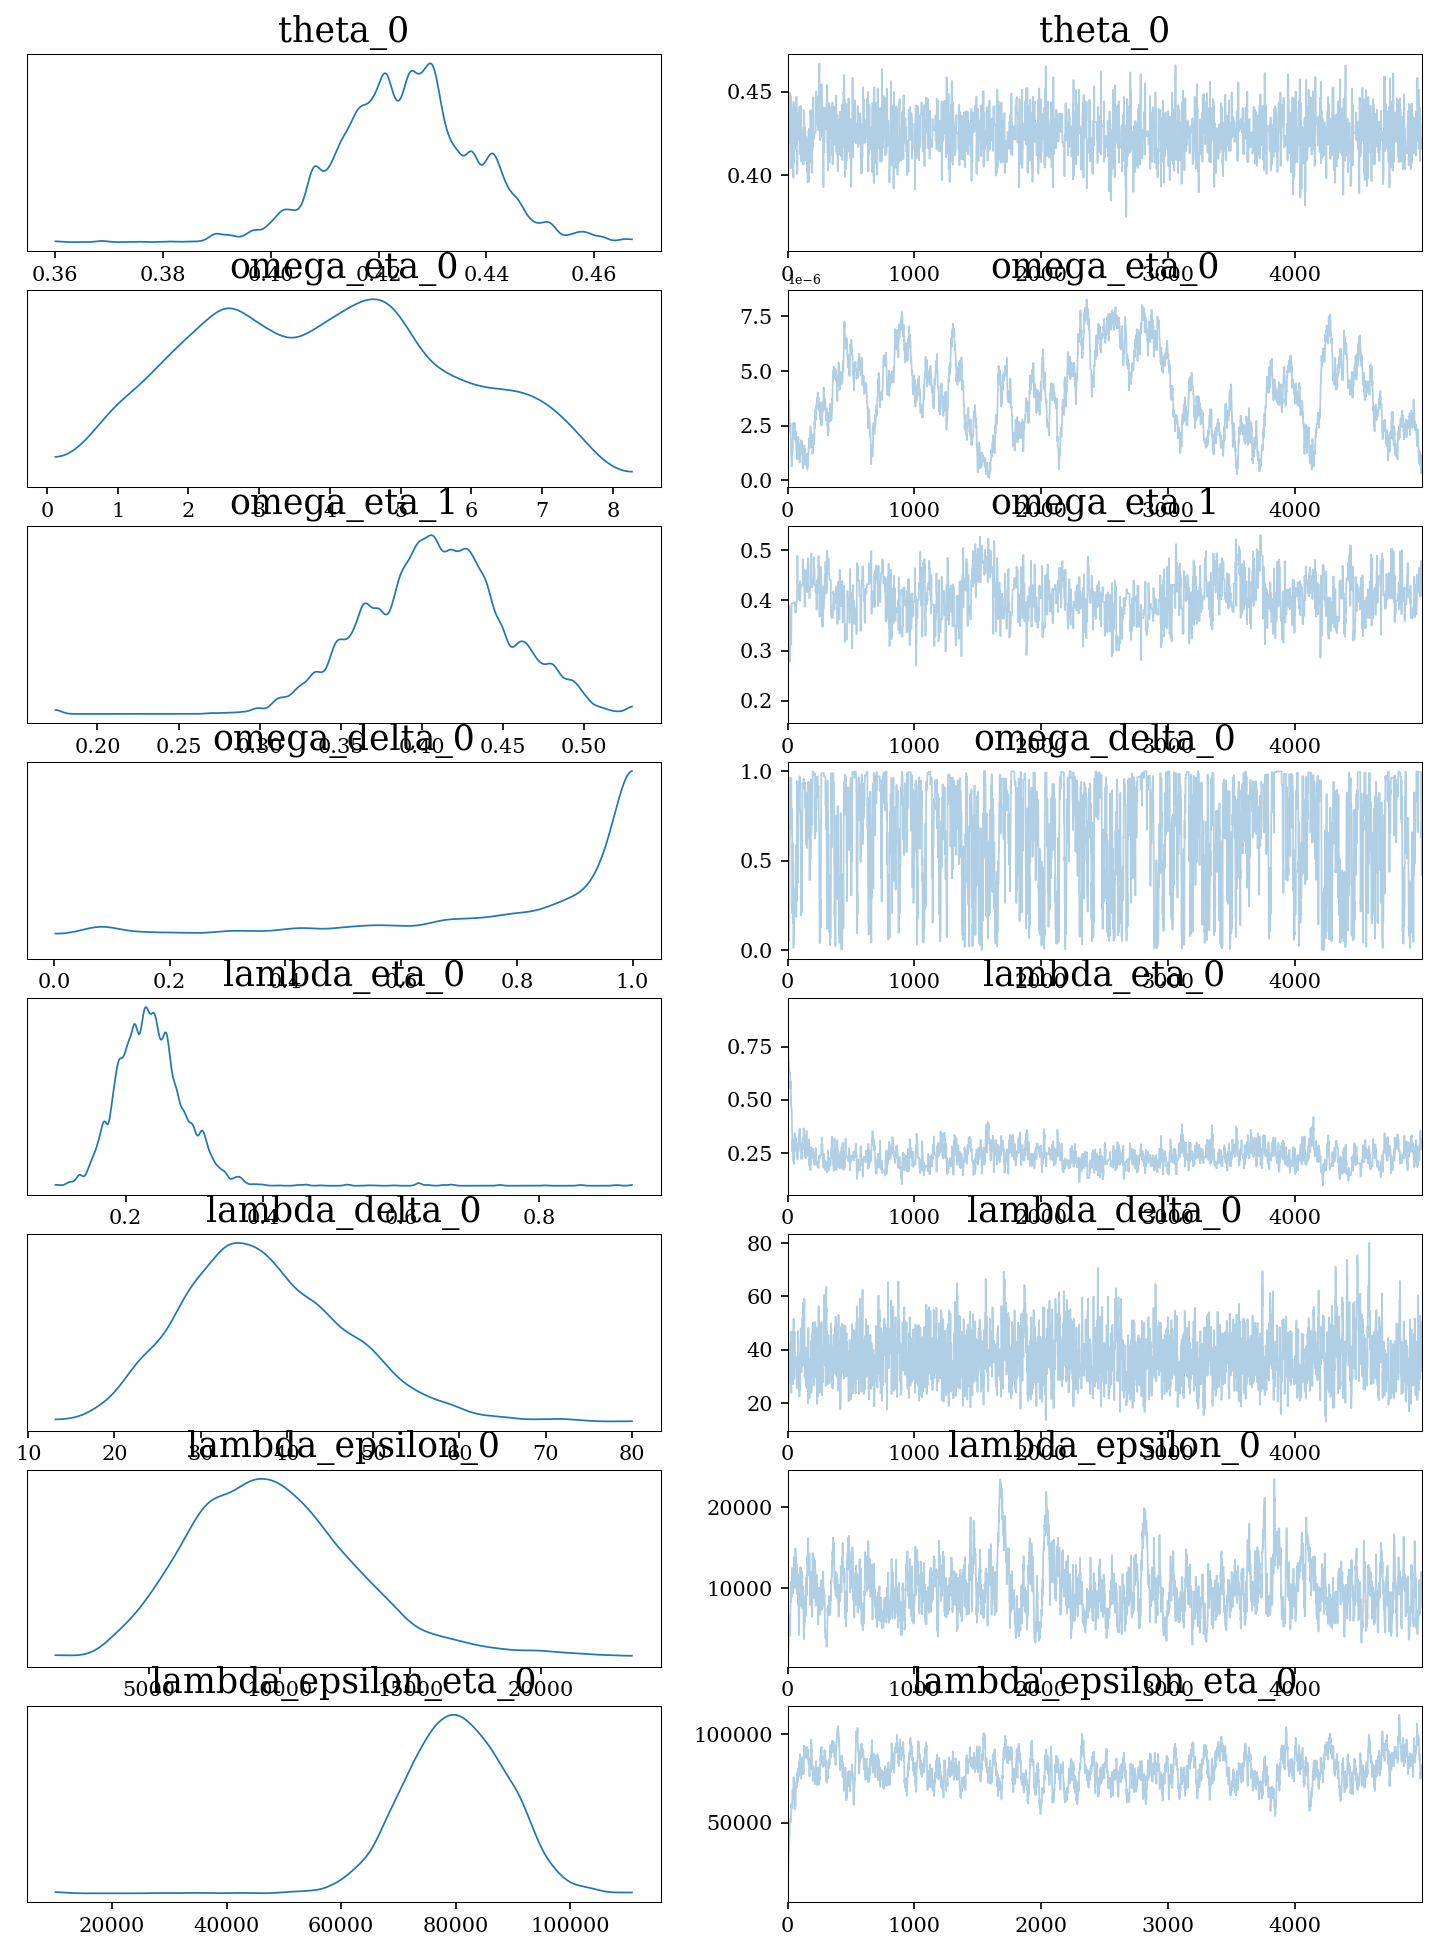

In [ ]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        mcmc.chain._chain
    )